# Halflife Regression - Analysis

Last year [Burr Settles](http://burrsettles.com/) (from [Duolingo](https://www.duolingo.com/)) and [Brendan Meeder](http://www.cs.cmu.edu/~bmeeder/) proposed a model predicting the probability of recall during the practice with Duolingo based on the lag time since a particular item was last presented by a learner. The original paper is called [A Trainable Spaced Repetition Model for Language Learning](https://aclweb.org/anthology/P/P16/P16-1174.pdf) ([video](https://www.youtube.com/watch?v=uqI2Bv2Av5s)) and the idea is also described in this [blog post](http://making.duolingo.com/how-we-learn-how-you-learn).

Since I am a Ph.D. candidate in [Adaptive Learning Group](www.fi.muni.cz/adaptivelearning/) and [my research](https://scholar.google.cz/citations?user=ozn2O8gAAAAJ&hl=cs) is focused on computerized adaptive practice of factual knowledge and issues related to its evaluation, I am very interested in papers produced by Duolingo employees (e.g., I recommend a paper [Mixture Modeling of Individual Learning Curves](http://www.educationaldatamining.org/EDM2015/uploads/papers/paper_133.pdf)). I presented the paper at our seminar on March 22 and thanks to the fact that authors published not only the paper, but also [the source code of the model](https://github.com/duolingo/halflife-regression) and [data used for its evaluation](https://s3.amazonaws.com/duolingo-papers/publications/settles.acl16.learning_traces.13m.csv.g), I was able to analyze behavior of the model and its evaluation more closely.

To understand the analysis which follows, please read [the original paper](https://aclweb.org/anthology/P/P16/P16-1174.pdf) or [blog post](http://making.duolingo.com/how-we-learn-how-you-learn). The full code of this analysis is available on [GitHub](https://github.com/papousek/duolingo-halflife-regression) and is based on the fork of the original repository to minimize the probability of my error.

If you want to this Jupyter notebook on your own, please download the [original data set](https://s3.amazonaws.com/duolingo-papers/publications/settles.acl16.learning_traces.13m.csv.gz) to the **data** directory and run the experiment:

```
pypy experiment.py -m hlr ./data/settles.acl16.learning_traces.13m.csv.gz
```

After you run the command above, you should see something like this in your console:

```
method = "hlr"
reading data...0...1000000...2000000...3000000...4000000...5000000...6000000...
7000000...8000000...9000000...10000000...11000000...12000000...done!
|train| = 11568803
|test|  = 1285423
test	191801294.6 (p=109014.3, h=191692154.1, l2=126.2)	mae(p)=0.129
	cor(p)=0.038	mae(h)=117.454	cor(h)=0.203
```

In [82]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from evaluation import plot_model_stats
from models import train_test_set, ItemAverage
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="white")

DAY_SECONDS = 60 * 60 * 24

## Analysis of the Input Traces

Since the paper is about finding the optimal learner model handling forgetting, we start with the analysis of available data, because the data usually matters a lot, see [Impact of Data Collection on Interpretation and Evaluation of Student Models](http://dl.acm.org/citation.cfm?id=2883868).

In [84]:
traces = pd.read_csv('./data/settles.acl16.learning_traces.13m.csv.gz')

In [85]:
traces['delta_days'] = traces['delta'].apply(lambda d: d / DAY_SECONDS)

In [88]:
traces.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,delta_days
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2,320.018924
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1,320.018924
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1,320.018924
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1,320.018924
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1,320.018924


### Observed Recall Rate

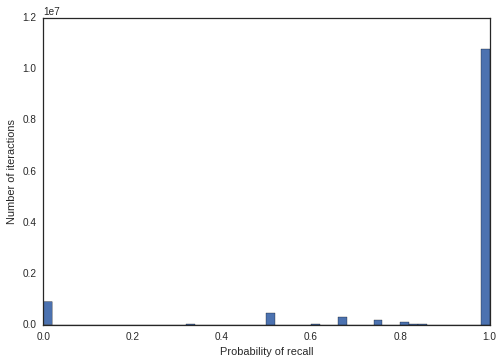

In [103]:
plt.hist(traces['p_recall'], bins=50)
plt.ylabel('Number of iteractions')
plt.xlabel('Probability of recall')
plt.show()

The most of interactions leads to high probability of recall. There is a danger that the proposed model will ignore some interactions to achieve higher accuracy

### Distribution of Lag Times

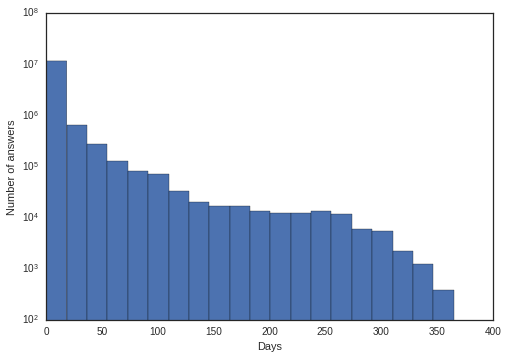

In [89]:
plt.hist([x for x in traces['delta_days'] if x < 365], bins=20)
plt.xlabel('Days')
plt.ylabel('Number of answers')
plt.yscale('log')
plt.show()

You can see that the most of the interactions have only small lag time, so the fitted model will probably focus mainly on the interactions having lag time lower than 10 days.

### Length of Traces

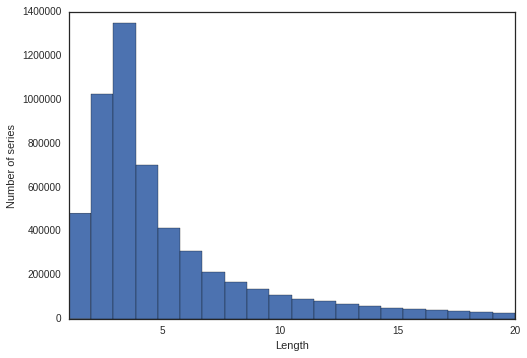

In [90]:
plt.hist([
    x for x in traces.sort_values(by=['timestamp']).drop_duplicates(['user_id', 'lexeme_id'])['history_seen']
    if x <= 20
], bins=20)
plt.xlim(1, 20)
plt.xlabel('Length')
plt.ylabel('Number of series')
plt.show()

The most of series (a learner's interactions for one item) has a length of three, or two.

### Forgetting

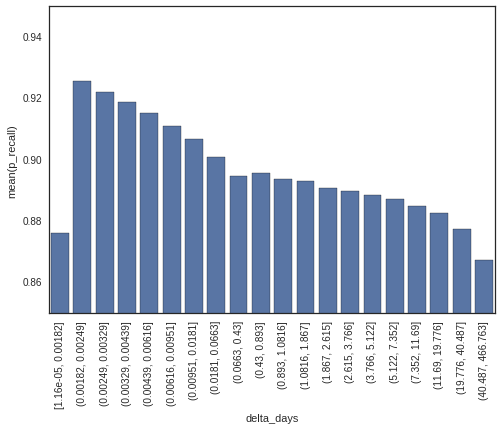

In [91]:
def _compute_bin_p_recall(group):
    return pd.DataFrame([
        {'p_recall': group['p_recall'].mean()}
    ])
global_forgetting = traces.groupby(
    pd.qcut(traces['delta_days'], 20)
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)
sns.barplot(x='delta_days', y='p_recall', data=global_forgetting, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.85, 0.95)
plt.show()

Suprisingly, the probability of recall does not only decrease with higher lag time. An average probability of the recall is the lowest in the case of really low lag time. Probably, in this case lexemes are not fully learned yet. Unfortunately, this phenomenon is not handled by the proposed model by design.

## Analysis of the Results

The paper presents the following features used in half-life regression:

1. interaction features
 - number of all correct answers (square root)
 - number of all wrong answers (square root)
2. lexeme tag features
 - bias dependent on a lexeme
 
I really do not underestand why there is no learners' feature (e.g., UI language, or estimated prior skill).

In [92]:
results = pd.read_csv('./results/hlr.settles.acl16.learning_traces.13m.preds', delimiter='\t')

In [104]:
results.head()

,p,pp,h,hh,lang,user_id,timestamp
0,0.9999,0.8741,274,168.7282,en->fr,u:dHVF,1363009539
1,0.9999,0.9136,274,175.2046,en->fr,u:dHVF,1363009539
2,0.9999,0.8803,274,124.2595,en->fr,u:dHVF,1363009539
3,0.9999,0.8969,274,145.5307,en->fr,u:dHVF,1363009539
4,0.9999,0.9005,274,165.1536,en->fr,u:dHVF,1363009539


### Calibration

RMSE: 0.2912178924698432
MAE: 0.128756880575
AUC: 0.537534701083


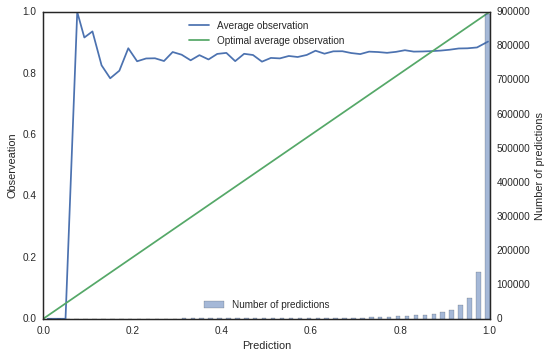

In [94]:
plot_model_stats(results['pp'], results['p'], bins=50)

Using MAE for the evalution of a learner model is questionable, see [Metrics for Evaluation of Student Models](http://www.educationaldatamining.org/JEDM/index.php/JEDM/article/download/JEDM087/pdf_12) paper for more information. The final model is really bad in the predictive accuracy (ideally, the blue line should be aligned with the green one). It seems that the presented model has almost no predictive power. Also the diversity of predictions is really low, almost all predictions are near to one.



### Comparison to Item Average

Imagine a learner model which ignores learning and forgetting. This model just computes an average probability of recall per item and uses it as a prediction for the future interactions.

It is worth noting that train/test division is not the same as the one used to fit and evaluate half-life regression model. However, I assume it does not affect a general messsage of the analysis.

In [95]:
trainset, testset = train_test_set(traces)

In [96]:
item_average = ItemAverage()
item_average.train(trainset)

RMSE: 0.26902643250089264
MAE: 0.170920653476
AUC: 0.606297726705


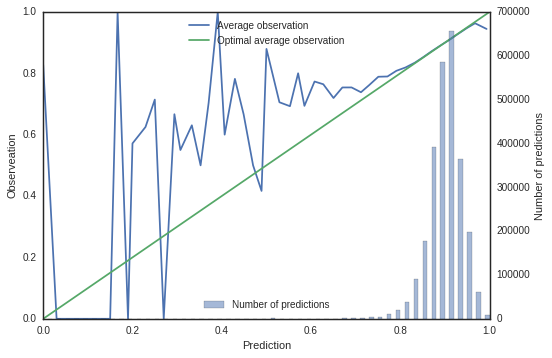

In [97]:
predicted = np.zeros(len(testset))
for i, lexeme_id in enumerate(testset['lexeme_id'].values):
    predicted[i] = item_average.predict(lexeme_id)
plot_model_stats(predicted, testset['p_recall'], 50)

You can see that even this simple model is much better than the one presented in the original paper. I understand that the goal of the paper is to find a parameter controlling degradation of skill meters and good predictive accuracy is a bonus. However, I assume that if there is a model ignoring learning and forgetting better than the proposed one, there is also a much better model taking learning and fogetting into accout.